In [58]:
from midiutil import MIDIFile
import rebound
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call

In [59]:
class PlanetBeat():
    def __init__(self, sim, bpm, time_per_beat=None, dt=None, outer_midi_note=48, movie=False, fps=30):
        self.midi = MIDIFile(adjust_origin=True) # One track, defaults to format 1 (tempo track automatically created)
        self.sim = sim
        if not dt:
            self.sim.dt = self.sim.particles[1].P/100. # use small timestep to get transits right. This is not the bottleneck
        else:
            self.sim.dt = dt
        self.movie=movie
        if movie:
            call("rm -f pngs/*", shell=True)
        self.time_per_fig = bpm/60./fps # time between figure savings
        self.fig_time = 0
        self.fig_ctr = 0
        
        self.notes = self.calc_midi_notes(outer_midi_note)
        self.set_time_per_beat(time_per_beat)
        self.change_tempo(bpm)
        
    def calc_midi_notes(self, outer_midi_note):
        # 12 notes between octaves, freq = f0*2**(n/12). 
        # n = 12 log_2(freq/f0)
        # star, then planets from inside out
        ps = sim.particles
        midinotes = [0] # placeholder for star
        for p in ps[1:]:
            midinote = outer_midi_note+12*np.log(ps[-1].P/p.P)/np.log(2)
            midinotes.append(int(np.round(midinote)))
        return midinotes  
    def set_time_per_beat(self, time_per_beat=None): # makes sim.t run in units of the outer planet orbit = one beat
        ps = self.sim.particles
        if time_per_beat is None:
            time_per_beat = ps[-1].P
        self.sim.G = time_per_beat**2
        self.sim.dt /= time_per_beat
        for p in ps:
            p.vx *= time_per_beat
            p.vy *= time_per_beat
            p.vz *= time_per_beat
    def integrate(self, numbeats, planets=[], color=True, duration=1, volume=100, track=0, channel=0, transparent=True):
        tmax = self.sim.t + numbeats
        N=self.sim.N
        ps = self.sim.particles
        if not planets: # by default do all planets
            planets = range(1,N)

        lw=3
        scale=ps[1].a/5 # length scale for making dots bigger
        refsize=25*lw # this is what REBOUND uses for size of circles in call to plt.scatter
        
        yprev = np.zeros(N)
        while self.sim.t < tmax:
            self.sim.step()
            self.fig_time += self.sim.dt
            for j in planets:
                if yprev[j] < 0 and ps[j].y > 0:
                    print(self.sim.t, j)
                    self.midi.addNote(track, channel, self.notes[j], self.sim.t, duration, volume)
                yprev[j] = ps[j].y
            if self.movie:
                if self.fig_time > self.time_per_fig:
                    fig = rebound.OrbitPlot(sim, figsize=(8,8), color=color, lw=lw, plotparticles=planets)
                    ax = fig.axes[0]
                    ax.axis('off')
                    for k in planets:
                        p = ps[k]
                        if p.x > 0:
                            ax.scatter(p.x, p.y, s=refsize*(1+5*np.exp(-np.abs(p.y)/scale)),color='k', marker='o')
                    fig.savefig('pngs/{0:0=5d}.png'.format(self.fig_ctr), transparent=transparent)
                    plt.close(fig)
                    
                    self.fig_time = 0
                    self.fig_ctr += 1
    def change_tempo(self, tempo):
        self.midi.addTempo(0, self.sim.t, tempo)
    def write_midi(self, filename):
        with open(filename, "wb") as f:
            self.midi.writeFile(f)

In [60]:
%%time
sim = rebound.Simulation.from_file("trappist.bin")
sim.t = 0
ps = sim.particles

pb = PlanetBeat(sim, bpm=30, time_per_beat=ps[-1].P, outer_midi_note=48, movie=True) # notes: http://subsynth.sourceforge.net/midinote2freq.html
planets = []
for i in range(1,sim.N):
    planets.append(-i)
    pb.integrate(numbeats=4, planets=planets, duration=1, color=['red', 'cyan'])
    
filename = "transits.mid"
pb.write_midi("transits.mid")

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


0.028129343209743 -1
1.0283756944032767 -1
2.027794711972785 -1
3.0280410631661088 -1
4.027460080735617 -1
4.128394782841147 -2
4.793571016389064 -2
5.027706431928941 -1
5.458747249936982 -2
6.027952783122265 -1
6.123096149861084 -2
6.7882723834090015 -2
7.027371800691773 -1
7.452621283333103 -2
8.027618151885155 -1
8.117797516881273 -2
8.398263615355438 -3
8.78297375043062 -2
8.895491123269812 -3
9.02703716945681 -1
9.393545964808004 -3
9.447322650356147 -2
9.891600806346196 -3
10.027283520652281 -1
10.112498883905493 -2
10.389655647884387 -3
10.777675117454839 -2
10.88771048942258 -3
11.026702538223935 -1
11.385765330960771 -3
11.442024017380367 -2
11.883820172498963 -3
12.026948889419407 -1
12.107200250929713 -2
12.271012308445597 -4
12.381875014037155 -3
12.601945757972635 -4
12.771549150855241 -2
12.879929855575346 -3
12.93370654112349 -4
13.02636790699106 -1
13.265467324274345 -4
13.377984697113538 -3
13.436725384404587 -2
13.5972281074252 -4
13.87603953865173 -3
13.9289888905760

In [61]:
filename = "test.mp4"
fps = 30
try:
    call("rm -f {0}".format(filename), shell=True)
except:
    pass
call("ffmpeg -r {0} -i pngs/%05d.png -c:v libx264 -pix_fmt yuv420p {1}".format(fps, filename), shell=True)

0

In [62]:
call("open "+filename, shell=True)

0

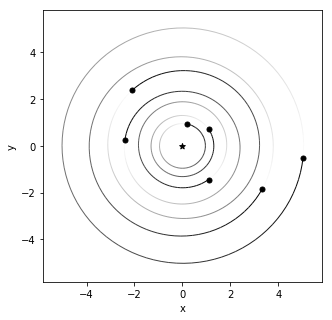

In [5]:
rebound.OrbitPlot(sim)

Period ratios

In [94]:
for i in range(1,7):
    print(ps[i+1].P/ps[i].P)

1.6009208063239937
1.6679113018571639
1.5009741278685107
1.501939182994456
1.335390113399473
1.5037062845692097
